In [1]:
import data_load
import pandas as pd
import glob
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta


In [2]:
cdc_frames = data_load.get_cdc_dataframe ()

In [3]:
jhu_frames = data_load.get_jhu_dataframe ()

In [4]:
def add_days(date, days):
    date_1 = datetime.strptime(date, "%Y-%m-%d")
    end_date = date_1 + timedelta(days=days)
    return end_date.strftime('%Y-%m-%d')

In [5]:
jhu_weekly={}
for target_date in cdc_frames.target_end_date.unique():
    if not target_date in jhu_frames.index:
        continue
    weeklySum = jhu_frames.loc[target_date].NewCases
    for i in range(6):
        pastDate = add_days(target_date, -(i+1))
        weeklySum += jhu_frames.loc[pastDate].NewCases
    jhu_weekly[target_date] = weeklySum

In [6]:
jhu_weekly_df = pd.DataFrame.from_dict(jhu_weekly,orient='index', columns=['WeeklyCases']).sort_index(ascending=True)
jhu_weekly_df = jhu_weekly_df.reset_index()
jhu_weekly_df = jhu_weekly_df.rename(columns={"index": "target_end_date"})
jhu_weekly_df.target_end_date=pd.to_datetime(jhu_weekly_df.target_end_date)
jhu_weekly_df = jhu_weekly_df.set_index("target_end_date", drop=True).sort_index(ascending=True)

In [7]:
start = "2020-03-01"
end = "2021-08-31"
stats={}

target_times_names = ["One Weeks", "Two Weeks", "Three Weeks", "Four Weeks"]
target_times = ["1", "2", "3", "4"]
for t in target_times_names:
    stats[t] = {}

for model in cdc_frames.Model.unique():
    if model == "DDS-NBDS":
        continue
        
    for idx, target_time in enumerate(target_times):
        
        model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == str(target_time) + " wk ahead inc case")][["target_end_date", "point"]]
        model_frame = model_frame.set_index("target_end_date", drop=True)
        model_frame = model_frame.sort_index()
        model_target_df = model_frame[(model_frame.index > start) & (model_frame.index < end)]
        target_dates = model_target_df.index.unique()
        jnu_target_df = jhu_weekly_df.loc[list(target_dates)]
        jnu_target_df.diff = 100*abs(model_target_df.point - jnu_target_df.WeeklyCases)/jnu_target_df.WeeklyCases
        if len(jnu_target_df)>3:
            stats[target_times_names[idx]][model]={}
            stats[target_times_names[idx]][model]= round(jnu_target_df.diff.mean(),2)

In [8]:
stat_df =  pd.DataFrame.from_dict(stats)
stat_df= stat_df.rename_axis('model').reset_index()

In [9]:
stat_df = stat_df.melt(id_vars=["model"], var_name="Target",  value_name="Point")

In [10]:
!pip install seaborn

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

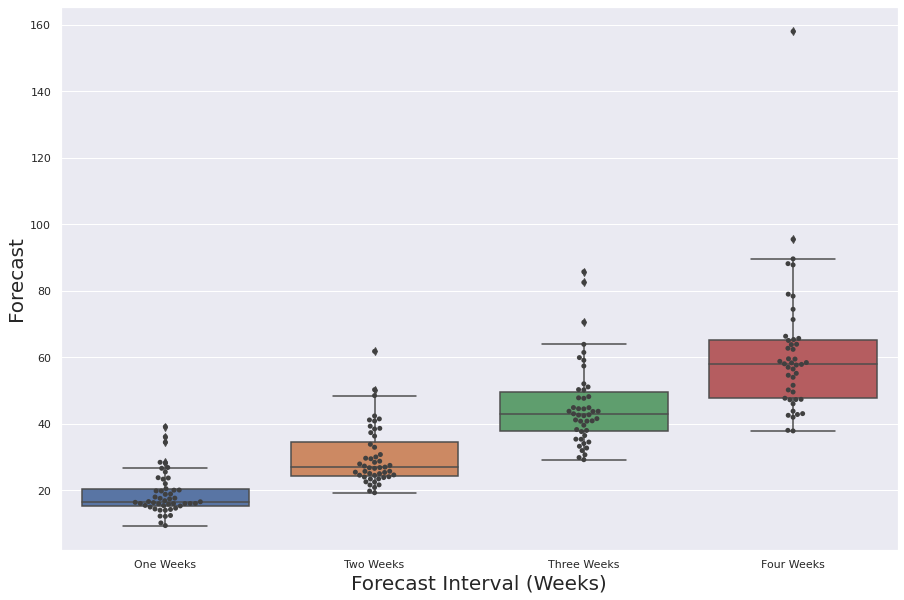

In [12]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.boxplot(x="Target", y="Point", data=stat_df)
ax = sns.swarmplot(x="Target", y="Point", data=stat_df, color=".25")

ax.set_xlabel("Forecast Interval (Weeks)",fontsize=20)
ax.set_ylabel("Forecast",fontsize=20)

ax.figure.savefig("plots/forecast_interval_swarm.png")

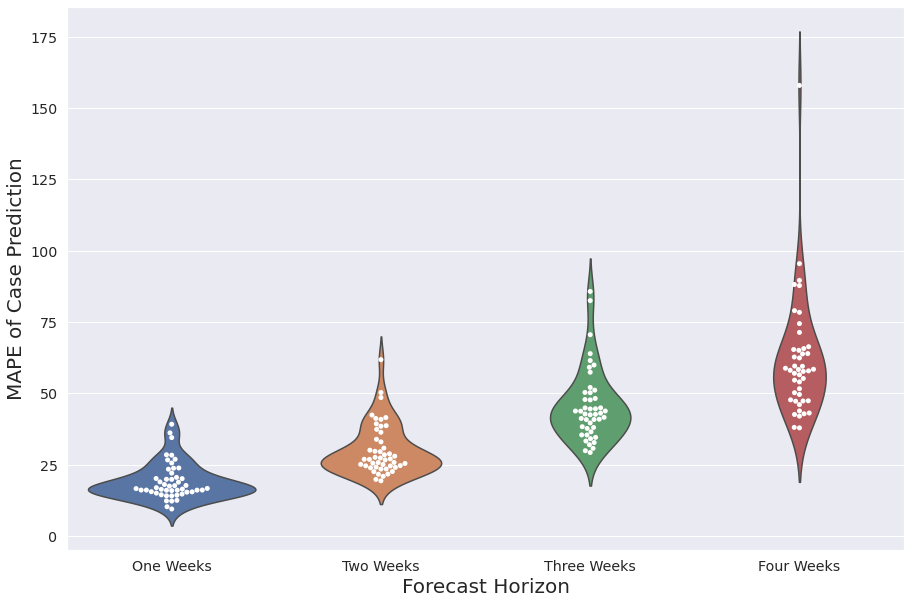

In [21]:

sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 1.3)
ax = sns.violinplot(x="Target", y="Point", data=stat_df, inner=None)
ax = sns.swarmplot(x="Target", y="Point", data=stat_df, color="white", edgecolor="gray")

ax.set_xlabel("Forecast Horizon",fontsize=20)
ax.set_ylabel("MAPE of Case Prediction",fontsize=20)
#ax.set_xticklabels(ax.get_xticks(), size = 15)

ax.figure.savefig("plots/forecast_interval_VIOLIN.png")



In [133]:
start = "2020-03-01"
end = "2021-08-31"
stats={}

target_times_names = ["One Weeks", "Two Weeks", "Three Weeks", "Four Weeks"]
target_times = ["1", "2", "3", "4"]
for t in target_times_names:
    stats[t] = {}

for model in cdc_frames.Model.unique():
    if model == "DDS-NBDS":
        continue
        
    for idx, target_time in enumerate(target_times):
        
        model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == str(target_time) + " wk ahead inc case")][["target_end_date", "point"]]
        model_frame = model_frame.set_index("target_end_date", drop=True)
        model_frame = model_frame.sort_index()
        model_target_df = model_frame[(model_frame.index > start) & (model_frame.index < end)]
        target_dates = model_target_df.index.unique()
        jnu_target_df = jhu_weekly_df.loc[list(target_dates)]
        jnu_target_df.diff = 100*abs(model_target_df.point - jnu_target_df.WeeklyCases)/jnu_target_df.WeeklyCases
        if len(jnu_target_df)>3:
            stats[target_times_names[idx]][model]={}
            stats[target_times_names[idx]][model]= round(jnu_target_df.diff.mean(),2)

In [143]:
stat_df =  pd.DataFrame.from_dict(stats)
stat_df= stat_df.rename_axis('model').reset_index()